#### 1.3.3 Data organization and standardization

Libraries for creating the tuple dataset:

In [1]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt

The following code reads the cropped images and organizes into a random sequenced tuple structure based on the label.

(32, 32)
(32, 32)
It is a mole.


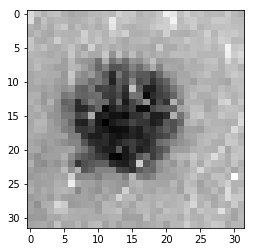

In [2]:
imgs = []
labels = []
for file_path in glob.glob('Cropped/*.bmp'):  # grabbing path of the cropped images
    if file_path:
        imgs.append(np.asarray(Image.open(file_path).convert('L')))  # reading mole images and labels
        labels.append(1)  # reading background images and labels

for file_path in glob.glob('CroppedBCKG/*.bmp'):  # grabbing path of the cropped images
    if file_path:
        imgs.append(np.asarray(Image.open(file_path).convert('L')))  # reading mole images and labels
        labels.append(0)  # reading background images and labels

imgs = np.asarray(imgs)
labels = np.asarray(labels)
    
s = np.arange(len(imgs))
np.random.shuffle(s)
imgs = imgs[s]
labels = labels[s]

dataset = [imgs, labels]

#Example:
#Second dim: i-th image
#First dim: 0 - image data; 1 - label data
plt.imshow(dataset[0][0], cmap='gray')
if dataset[1][0]==1:
    print('It is a mole.')
else:
    print('It is not a mole.')
    
# organize the dataset into a tuple
dataset = (dataset[0], dataset[1])

The following code separates the dataset into validation, test and train subsets. Based on the training set standardization executed on the three sets, on each channel separately. After that the separated, standardized R, G , B channels rearranged.

In [3]:
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
# mole or not mole
nb_classes = 2

# separating inputs and outputs
X, Y = dataset

# ratio of validation samples
test_split = 0.1
valid_split = 0.1

#Indeces of the subsets
v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

#Splitting the dataset into test, validation and train subsets
X_train = X[:t_index].astype('float32')
Y_train = Y[:t_index]
X_valid = X[v_index:t_index].astype('float32')
Y_valid = Y[v_index:t_index]
X_test = X[t_index:].astype('float32')
Y_test = Y[t_index:]

# dimensions of our images.
img_width, img_height = X_train.shape[1], X_train.shape[2]

# standard
X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

print('X_train max: ',X_train.max())
print('X_train min: ',X_train.min())
print('X_valid max: ',X_valid.max())
print('X_valid min: ',X_valid.min())
print('X_test max: ',X_test.max())
print('X_test min: ',X_test.min())

print('X train shape: ', X_train.shape)
print('Y train shape: ', Y_train.shape)
print('X valid shape: ', X_valid.shape)
print('Y valid shape: ', Y_valid.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', Y_test.shape)
print(X_train.shape[0], 'train samples')

X_train max:  1.0
X_train min:  0.0
X_valid max:  1.0
X_valid min:  0.0
X_test max:  1.0
X_test min:  0.0
X train shape:  (2756, 32, 32)
Y train shape:  (2756,)
X valid shape:  (306, 32, 32)
Y valid shape:  (306,)
X test shape:  (307, 32, 32)
Y test shape:  (307,)
2756 train samples


In [5]:
# convert class vectors to binary class matrices:
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_valid = np_utils.to_categorical(Y_valid, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)
print(Y_train.shape)

(2756, 2)


In [6]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(1024,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                10250     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 10,382
Trainable params: 10,382
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)

(2756, 1024)


In [8]:
batch_size = 128
epochs = 20

patience = 5
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='Weights/mlp_weights.hdf5', save_best_only=True, verbose=1)

network_history = model.fit(X_train, Y_train,
                            batch_size=batch_size,
                            epochs=epochs, verbose=1,
                            validation_data=(X_valid, Y_valid),
                            callbacks=[checkpointer, early_stopping])

Train on 2756 samples, validate on 306 samples
Epoch 1/20
2756/2756 [==============================] - 0s 150us/step - loss: 0.6883 - acc: 0.5533 - val_loss: 0.6745 - val_acc: 0.8758

Epoch 00001: val_loss improved from inf to 0.67452, saving model to mlp_weights.hdf5
Epoch 2/20
2756/2756 [==============================] - 0s 59us/step - loss: 0.6643 - acc: 0.6829 - val_loss: 0.6490 - val_acc: 0.8889

Epoch 00002: val_loss improved from 0.67452 to 0.64904, saving model to mlp_weights.hdf5
Epoch 3/20
2756/2756 [==============================] - 0s 52us/step - loss: 0.6354 - acc: 0.6691 - val_loss: 0.5940 - val_acc: 0.8987

Epoch 00003: val_loss improved from 0.64904 to 0.59399, saving model to mlp_weights.hdf5
Epoch 4/20
2756/2756 [==============================] - 0s 47us/step - loss: 0.5736 - acc: 0.7993 - val_loss: 0.5261 - val_acc: 0.8791

Epoch 00004: val_loss improved from 0.59399 to 0.52605, saving model to mlp_weights.hdf5
Epoch 5/20
2756/2756 [==============================] - 

In [9]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
    plt.show()

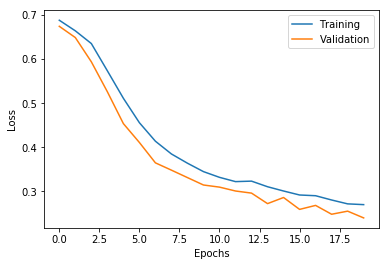

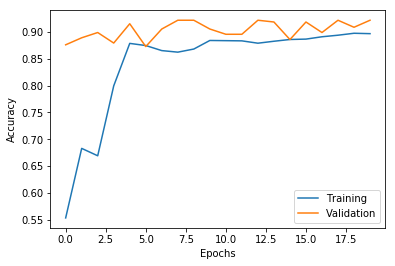

In [10]:
plot_history(network_history)